# ◆House Prices: Advanced Regression Techniques
### 目的：住宅価格を予測する
### 目的変数をSalePriceとする回帰問題として、Kerasを利用したニューラルネットワークモデルを構築する
- kaggle URL:https://www.kaggle.com/c/house-prices-advanced-regression-techniques
- Create Date：2020/01/17　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

### 【手順】

### 0.Notebook内で利用する関数の定義

### 1.データ読込
- 欠損項目を確認する

### 2.データ前処理
- 事前に予測できない項目は、除外する。
- 目的変数を説明するのに有効そうな説明変数を見つける。
- 目的変数と説明変数の関係を確認するためのグラフを作成する。
- 質的変数が扱えない場合は、ダミー変数に置き換える。

### 3.モデル構築
- ニューラルネットワークモデルを利用する

### 4.モデル検証
- MSE,RMSE,MAEを求める

### 5.予測結果提出

### ※データセット
- 「train.csv」（学習データ数：1460行81列）
- 「test.csv」（テストデータ数：1459行80列 ※SalePriceがない）

## 0.Notebook内で利用する関数の定義

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler # Used for scaling of data
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

seed = 1234
np.random.seed(seed)

# 警告非表示
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## 1.データ読込

In [2]:
train = pd.read_csv('./input/train.csv') #訓練データ
test = pd.read_csv('./input/test.csv') #テストデータ

print('The size of train is : ' + str(train.shape))
print('The size of test is : ' + str(test.shape))

print("\n▼ 先頭5行表示")
pd.set_option('display.max_columns', 400)
display(train.head(5))

# 学習データとテストデータのマージ
train['train'] = 1
test['train'] = 0
test['SalePrice'] = 9999999999

all_df = pd.concat([train,test],axis=0).reset_index(drop=True)

# 欠損状況確認
#print('\n ▼ trainデータの欠損状況 ')
#display(train.isnull().sum()[train.isnull().sum()>0].sort_values(ascending=False))

#print('\n ▼ testデータの欠損状況 ')
#display(test.isnull().sum()[test.isnull().sum()>0].sort_values(ascending=False))

# 欠損を含むカラムのリスト表示
na_col_list = all_df.isnull().sum()[all_df.isnull().sum()>0].index.tolist() 

print('\n ▼ 欠損を含むカラムの型リスト表示 ')
display(all_df[na_col_list].dtypes.sort_values()) 

The size of train is : (1460, 81)
The size of test is : (1459, 80)

▼ 先頭5行表示


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



 ▼ 欠損を含むカラムの型リスト表示 


MasVnrArea      float64
GarageArea      float64
TotalBsmtSF     float64
BsmtFinSF1      float64
BsmtFinSF2      float64
GarageYrBlt     float64
BsmtFullBath    float64
BsmtHalfBath    float64
GarageCars      float64
BsmtUnfSF       float64
LotFrontage     float64
GarageType       object
KitchenQual      object
Alley            object
MasVnrType       object
MiscFeature      object
PoolQC           object
SaleType         object
MSZoning         object
GarageQual       object
Functional       object
GarageCond       object
FireplaceQu      object
Fence            object
Exterior2nd      object
Exterior1st      object
Electrical       object
BsmtQual         object
BsmtFinType2     object
BsmtFinType1     object
BsmtExposure     object
BsmtCond         object
GarageFinish     object
Utilities        object
dtype: object

## 2.データ前処理


▼ SalePrice(住宅価格)の分布を確認


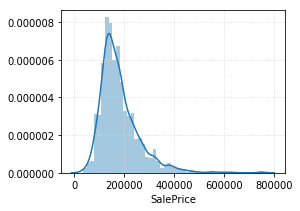

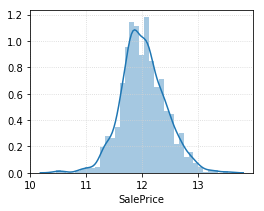

In [3]:
# 目的変数のヒストグラムを表示
print('\n▼ SalePrice(住宅価格)の分布を確認')
plt.figure(figsize=(4,3))
sns.distplot(train['SalePrice'])
plt.grid(which='major',color='lightgray',linestyle=':')
plt.grid(which='minor',color='lightgray',linestyle=':')
plt.show()

# 対数変換
plt.figure(figsize=(4,3))
plt.grid(which='major',color='lightgray',linestyle=':')
plt.grid(which='minor',color='lightgray',linestyle=':')
sns.distplot(np.log(train['SalePrice']))
plt.show()


In [4]:
# ****************************************************************************
# ◆ 2.前処理
# ****************************************************************************
# ------------------------------------------------
# 2-1.欠損値の補完
# ------------------------------------------------
# object変数の欠損：欠損を示す文字列’NA’を補完
# 数値型変数の欠損：0.0を補完

# float64リスト
na_float_cols = all_df[na_col_list].dtypes[all_df[na_col_list].dtypes=='float64'].index.tolist()

# objectリスト
na_obj_cols = all_df[na_col_list].dtypes[all_df[na_col_list].dtypes=='object'].index.tolist()

print('\n▼ 数値型欠損カラム----> 0.0 を補完：\n',na_float_cols)
print('\n▼ object型欠損カラム----> NA を補完：\n',na_obj_cols)

# float64型で欠損している場合は0を代入
for na_float_col in na_float_cols:
    all_df.loc[all_df[na_float_col].isnull(),na_float_col] = 0.0

# object型で欠損している場合は'NA'を代入
for na_obj_col in na_obj_cols:
    all_df.loc[all_df[na_obj_col].isnull(),na_obj_col] = 'NA'

#print('\n ▼ 欠損を含むカラムの型リスト表示 ')
#na_col_list = all_df.isnull().sum()[all_df.isnull().sum()>0].index.tolist() 
#display(all_df[na_col_list].dtypes.sort_values()) 


▼ 数値型欠損カラム----> 0.0 を補完：
 ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'TotalBsmtSF']

▼ object型欠損カラム----> NA を補完：
 ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'KitchenQual', 'MSZoning', 'MasVnrType', 'MiscFeature', 'PoolQC', 'SaleType', 'Utilities']


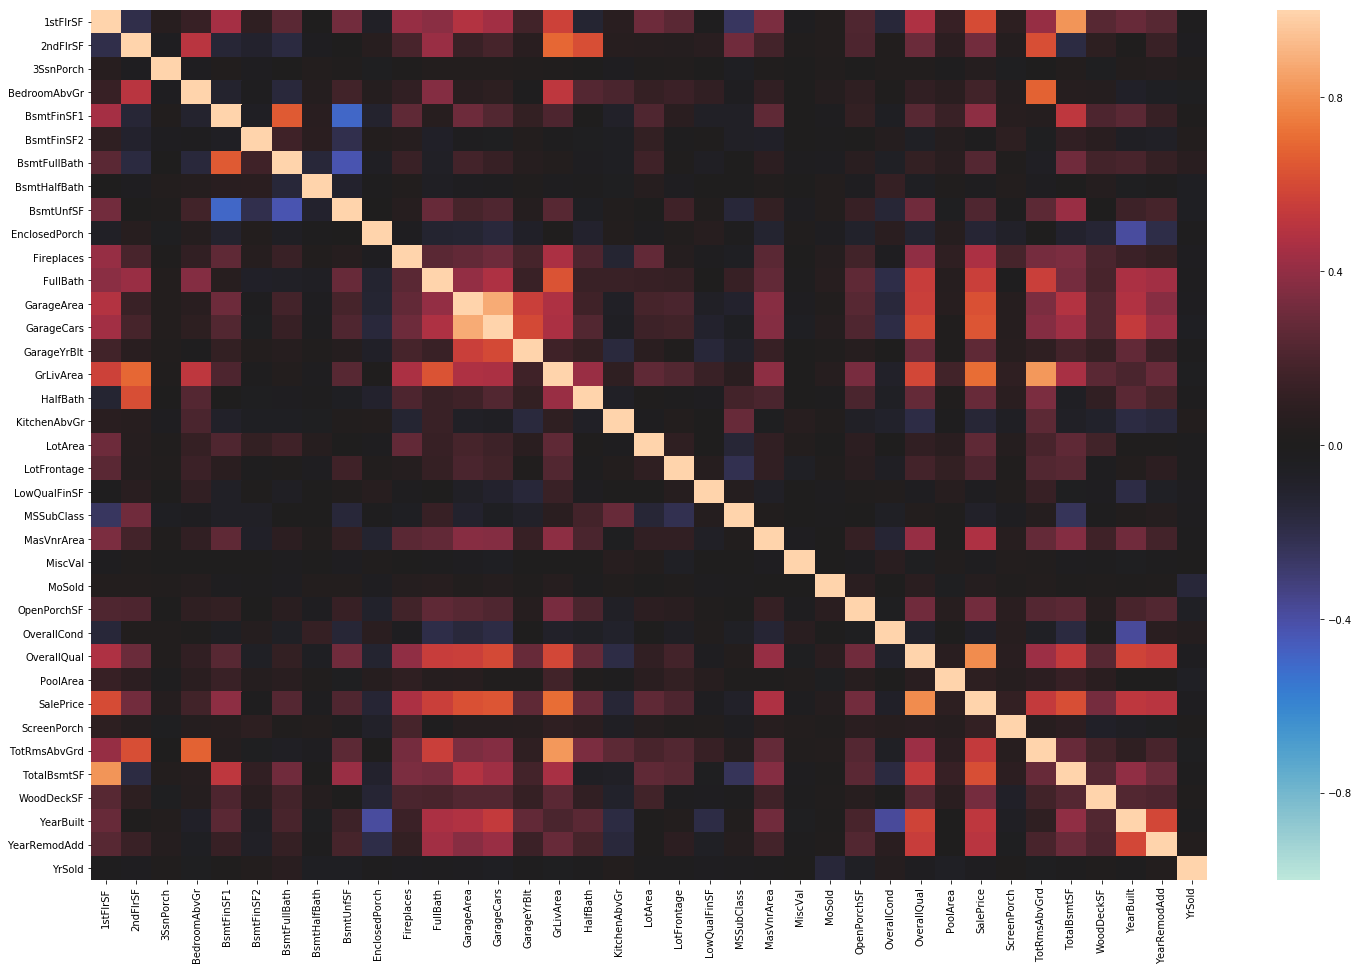

In [5]:
# SalePriceと相関の強い説明変数を見つける
train = all_df.query('train == 1')

corrmat = train.drop(['Id','train'],axis=1).corr()
f, ax = plt.subplots(figsize=(25, 16))
sns.heatmap(corrmat, annot=False, fmt='1.1f', vmax=1, vmin=-1, center=0)

SalePriceと相関が強い項目=
 ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']


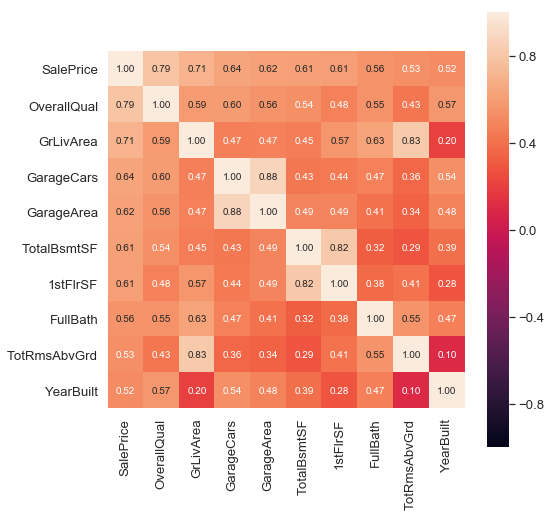

In [6]:
# SalePriceと相関させるために最も重要なトップ10をプロット
k = 10 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
print('SalePriceと相関が強い項目=\n',cols.tolist())
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.2)
f, ax = plt.subplots(figsize=(8, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, vmax=1, vmin=-1, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

このプロットから、次の結論を導き出すことができます。

- OverallQualは重要です
- GrLivAreaも重要です
- TotalBsmtSFは重要です
- GarageCarsとGarageAreaは2つの重要な機能ですが、GarageCarsとほぼ同じ情報であるため、GarageAreaは削除します。
- TotalBsmtSFと1stFlrSFもほぼ同じであるため、1StFlrSFを削除します
- TotRmsAbvGrdとGrLivAreaも強く相関しており、TotRmsAbvGrdを削除します

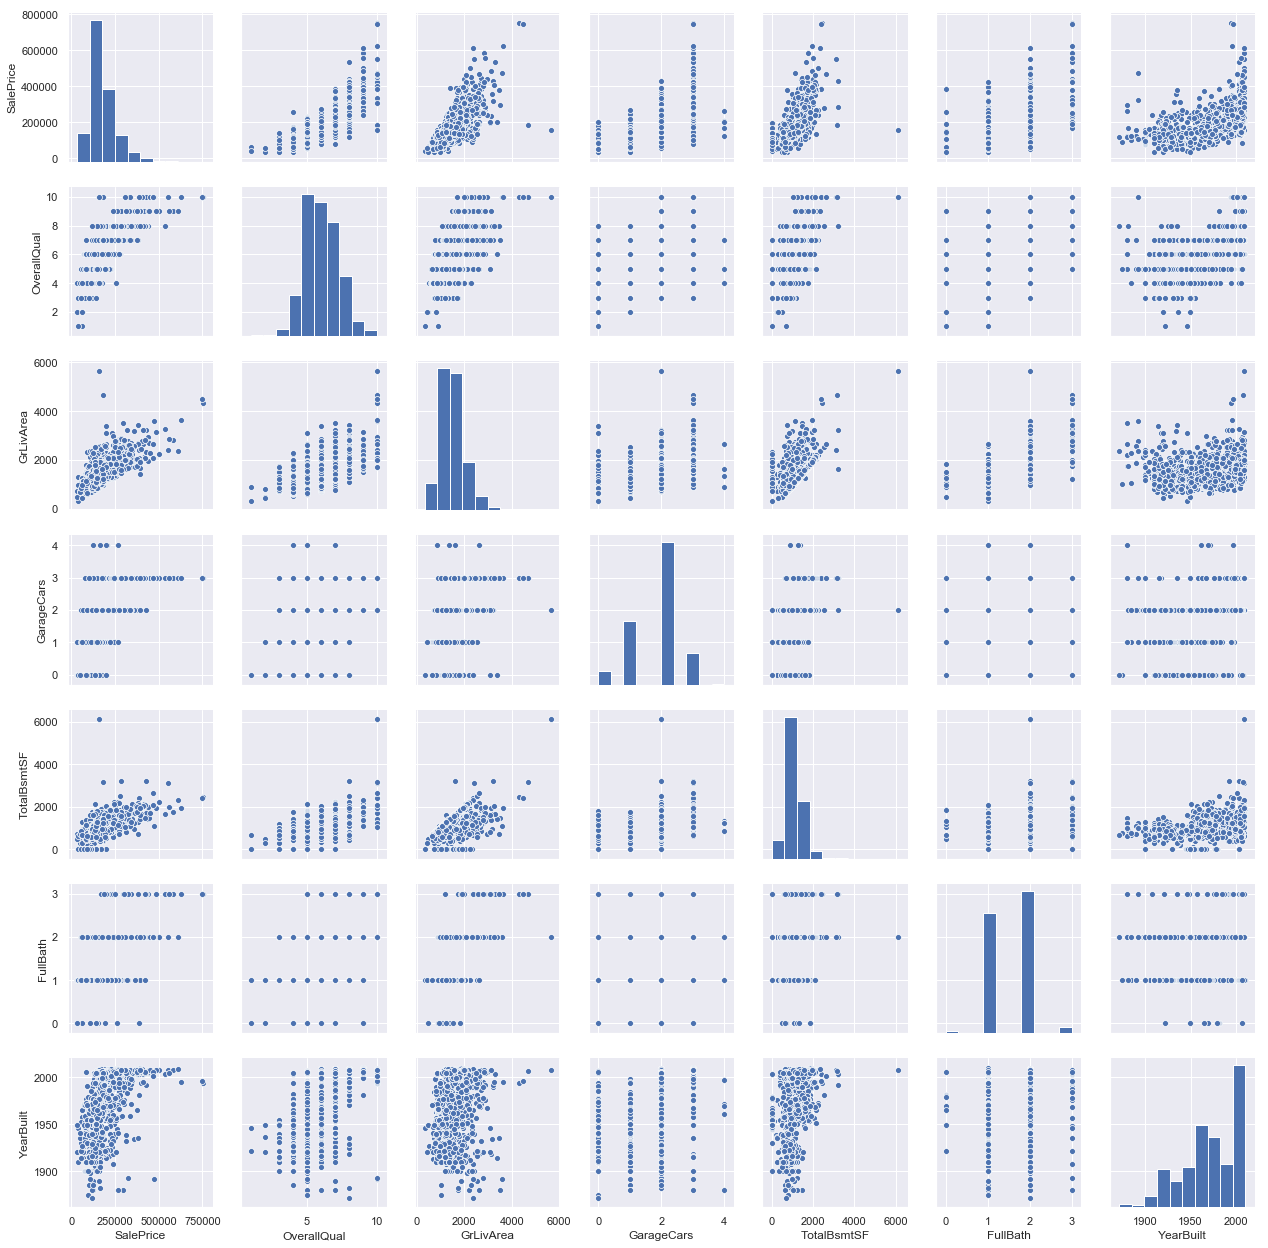

In [7]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

- 地下エリア（GrLivArea）と総居住エリア（TotalBsmtSF）は、販売価格のプロットがほぼ同じに見える類似点があるようです。
- 地下エリア（GrLivArea）を削除します。
- 作成年（YearBuilt）のデータも利用が難しいため、削除する可能性があります。

In [8]:
train = all_df.query('train == 1')

cols = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']
train = train[cols]

scale = StandardScaler()

X_train = train[['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']]
X_train = scale.fit_transform(X_train)

y = train['SalePrice'].values

X_train, X_test0, y_train, y_test0 = train_test_split(X_train, y, test_size=0.3, random_state=1234)


## 3.モデル構築





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 1,671
Trainable params: 1,671
Non-trainable params: 0
_________________________________________________________________
None




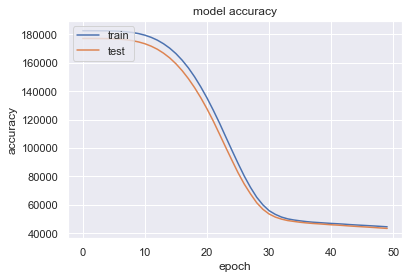

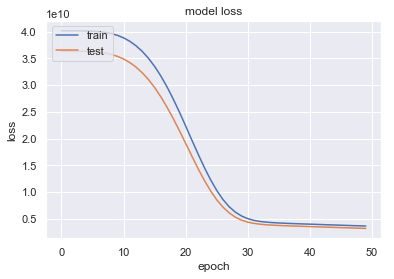

In [9]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer ='adam', loss = 'mean_squared_error', metrics =[metrics.mae])
    return model

model = create_model()

# モデルサマリ
print(model.summary())

# 学習
history = model.fit(X_train, y_train, validation_data=(X_test0,y_test0), epochs=50, batch_size=32, verbose=0)

# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 4.モデルの検証

In [10]:
y_test0_pred = model.predict(X_test0)

# 二乗誤差(MSE)を計算
mse = mean_squared_error(y_test0, y_test0_pred) 
print("平均二乗和誤差(MSE) = %s"%round(mse,3) )  

# 絶対値誤差(MAE)を計算
mae = mean_absolute_error(y_test0, y_test0_pred) 
print("平均絶対値誤差(MAE) = %s"%round(mae,3) )

# 平方根二乗誤差(RMSE)を計算
rmse = np.sqrt(mse)
print("平方根平均二乗和誤差(RMSE) = %s"%round(rmse, 3) )

平均二乗和誤差(MSE) = 3182894969.713
平均絶対値誤差(MAE) = 43461.77
平方根平均二乗和誤差(RMSE) = 56417.151


## 5.予測結果の出力

In [11]:
test = all_df.query('train == 0')
cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']
id_col = test['Id'].values.tolist()
test['GrLivArea'] = np.log1p(test['GrLivArea'])
test = pd.get_dummies(test)
X_test = test[cols].values
scale = StandardScaler()
X_test = scale.fit_transform(X_test)

prediction = model.predict(X_test)
submission = pd.DataFrame()
submission['Id'] = id_col
submission['SalePrice'] = prediction

submission.to_csv('./output/submission_Keras.csv', index=False)